#  <font color='#FFE15D'><b>💎 Train, Evaluate, and Generate Functions (LLM-specific) </b></font><font color='#FF0B55'><b>[Final]</b></font>

# 🔴 **Environment Setup**

## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


## 🟠 `pip`

# 🔴 **Import**

In [ ]:
import os
import sys
import time
import math
import json
import random
from tqdm import tqdm
from pprint import pprint
from itertools import cycle
from termcolor import colored
from dataclasses import dataclass
from prettytable import PrettyTable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datasets import load_dataset
from tokenizers import Tokenizer

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

from torchmetrics import MeanMetric

# 🔴 **Utils**

In [ ]:
def prepare_data(tokens, seq_len):
    # Trim tokens so that total length is divisible by seq_len
    n_tokens = (tokens.shape[0] // seq_len) * seq_len
    tokens = tokens[:n_tokens]
    # Reshape to 2D tensor
    return tokens.view(-1, seq_len)

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
# Benchmarking function
def calculate_time(model, x, num_runs=10):
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(num_runs):
        model(x)
    torch.cuda.synchronize()
    return (time.time() - start) / num_runs

# 🔴 **Dataset**

In [ ]:
class TinyStoriesDataset(Dataset):

    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = prepare_data(data, seq_len+1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample.long()#[:-1], sample[1:]

# 🔴 **Model**

## 🟠 Multi Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.head_size = self.n_embd // self.n_head

        self.qkv_proj = nn.Linear(self.n_embd, 3*self.n_embd, bias=False)
        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)
        self.c_proj.residual = True

    def forward(self, x):
        B, T, C = x.shape
        # QKV linear
        q, k, v = self.qkv_proj(x).view(B, T, 3*self.n_head, self.head_size).transpose(1, 2).chunk(3, dim=-3)
        # Scaled Dot Product Attention using pytorch
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        # Reshape and final projection
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y

## 🟠 Feed Forward (MLP)

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.f_expnd = config.f_expnd

        self.up_proj = nn.Linear(self.n_embd, int(self.f_expnd*self.n_embd), bias=False)
        self.down_proj = nn.Linear(int(self.f_expnd*self.n_embd), self.n_embd, bias=False)
        self.down_proj.residual = True

    def forward(self, x):
        return self.down_proj(F.gelu(self.up_proj(x)))

## 🟠 Decoder Block

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        # Multi Head Attention
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.mha = MultiHeadAttention(config)
        # Feed Forward Neural Network
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.mlp = FeedForward(config)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

## 🟠 GPT

In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # Token embedding
        self.wpe = nn.Embedding(config.max_seq_len, config.n_embd) # Position embedding
        self.decoders = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]) # Decoders
        self.lnf = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Classifier
        self.lm_head.weight = self.wte.weight # Weight tying

        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            if hasattr(module, 'residual'):
                std *= (2*self.config.n_layer)**-0.5
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx):
        B, T = idx.shape
        # Token Embedding + Position Embedding
        x = self.wte(idx) + self.wpe(torch.arange(T, device=idx.device))
        # Decoders
        for decoder in self.decoders:
            x = decoder(x)
        # Classifier
        x = self.lnf(x)
        logits = self.lm_head(x)
        return logits

# 🔴 **Functions ⚙️**

## 🟠 Logger

In [ ]:
# Logger class for saving and plotting training logs
class Logger:
    """
    Manages training history logging, saving to disk, and plotting learning curves.
    """
    def __init__(self, log_dir='logs', run_name='default_run'):
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
        self.run_name = run_name
        self.history = {
            'train_loss': [],
            'valid_loss': [],
            'best_loss_valid': float('inf'),
            'seen_tokens': []
        }

    def log(self, train_loss, valid_loss, seen_tokens):
        self.history['train_loss'].append(train_loss)
        self.history['valid_loss'].append(valid_loss)
        self.history['seen_tokens'].append(seen_tokens)

    def save(self):
        # Save history
        file_path = os.path.join(self.log_dir, f'{self.run_name}.json')
        with open(file_path, 'w') as f:
            json.dump(self.history, f, indent=4)
        # Save best model and optimizer
        current_loss_valid = self.history['valid_loss'][-1]
        if current_loss_valid < self.history['best_loss_valid']:
            log = dict(model=model.state_dict(), optimizer=optimizer)
            torch.save(log, f'{self.log_dir}/best-model.pt')
            self.history['best_loss_valid'] = current_loss_valid
            print("✅ Model Saved!")

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['seen_tokens'], self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['seen_tokens'], self.history['valid_loss'], label='Valid Loss')
        plt.xlabel('Seen Tokens')
        plt.ylabel('Loss')
        plt.title(f'Training Curve: {self.run_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.log_dir, f'{self.run_name}_curve.png'))
        plt.show()

## 🟠 Train ➰

In [ ]:
# Trainer class to manage model training, evaluation and reporting
class LLMTrainer:
    """
    Trainer handles training loops, periodic evaluation, logging, and sample generation.
    """
    def __init__(self, model, optimizer, train_loader, valid_loader, tokenizer,
                 loss_fn=F.cross_entropy, device='cuda',
                 total_tokens=10_000_000, log_interval_tokens=1_000_000,
                 generation=None):

        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.tokenizer = tokenizer
        self.loss_fn = loss_fn
        self.device = device

        self.seen_tokens = 0
        self.total_tokens = total_tokens
        self.token_eval_counter = 0
        self.log_interval_tokens = log_interval_tokens

        self.logger = Logger(log_dir='logs', run_name='gpt2_tinystories')
        self._print_config_summary()

        self.generation = generation

    def train(self):
        """
        Main training loop that stops when total token count is reached.
        """
        # Initial evaluation before any training
        initial_loss = self.evaluate()
        self.logger.log(initial_loss, initial_loss, 0)
        print(f"👶 [Initial] Train Loss (Untrained Model): {initial_loss:.4f}\n")

        loss_train = MeanMetric()
        self.model.train()
        train_iter = cycle(self.train_loader)

        batches = 0
        total_time_elapsed = 0
        start_time = time.time()

        with tqdm(total=self.total_tokens, desc="Training", unit="t") as pbar:
            while self.seen_tokens < self.total_tokens:
                # Get inputs
                inputs = next(train_iter).to(self.device)
                # Forward pass
                logits = self.model(inputs[:, :-1])
                # Calculate loss
                loss = self.loss_fn(logits.view(-1, logits.shape[-1]), inputs[:, 1:].flatten())
                # Backward pass
                loss.backward()
                # Clip gradients
                nn.utils.clip_grad.clip_grad_norm_(self.model.parameters(), max_norm=1.)
                # Update model
                self.optimizer.step()
                self.optimizer.zero_grad()
                # Calc running loss
                loss_train.update(loss.item(), inputs.shape[0])

                num_tokens_this_batch = inputs[:, :-1].numel()
                self.seen_tokens += num_tokens_this_batch
                self.token_eval_counter += num_tokens_this_batch
                batches += 1
                elapsed = time.time() - start_time
                batches_per_sec = batches / elapsed

                pbar.set_postfix({
                    "B/S": f"{batches_per_sec:.2f}",
                    "Loss": f"{loss_train.compute().item():.4f}",
                    "LR": f"{self.optimizer.param_groups[0]['lr']:.2e}",
                })
                pbar.update(num_tokens_this_batch)

                # Evaluate & Generate & Log
                if (self.token_eval_counter >= self.log_interval_tokens) or (self.seen_tokens >= self.total_tokens):
                    # Evaluate
                    loss_valid = self.evaluate()
                    print(f"\nValid Loss: {loss_valid:.4f}")
                    # Log
                    self.logger.log(loss_train.compute().item(), loss_valid, self.seen_tokens)
                    self.logger.save()
                    # Generate
                    if self.generation:
                        self.generate()
                    # Reset
                    self.token_eval_counter = 0
                    batches = 0
                    start_time = time.time()

        self.logger.plot()

    def evaluate(self):
        """
        Evaluate model on validation set.
        """
        loss_valid = MeanMetric()
        self.model.eval()
        with torch.no_grad():
            for inputs in self.valid_loader:
                inputs = inputs.to(self.device)
                logits = self.model(inputs[:, :-1])
                loss = self.loss_fn(logits.view(-1, logits.shape[-1]), inputs[:, 1:].flatten())
                loss_valid.update(loss.item(), inputs.shape[0])
        return loss_valid.compute().item()

    def generate(self):
        """
        Generate and print text samples from the model.
        """
        generated_texts = []
        for prompt in self.generation.prompts:
            gen_text = generate(
                self.model, self.tokenizer, prompt,
                n_rep=self.generation.n_rep,
                max_seq_len=self.generation.max_seq_len,
                T=self.generation.T, top_k=self.generation.top_k,
                seed=self.generation.seed)
            generated_texts.append(gen_text)
        # TODO: Save
        # Print
        # print(150*'.')
        # item = 0
        # prompt0 = self.generation.prompts[item]
        # for gen_text in generated_texts[item]:
        #     print(colored(f"\n{prompt0}", "green"), end='')
        #     print(colored(f"{gen_text[len(prompt0):]}", "cyan"))
        #     print(150*'.')
        # print()
        item = 0
        prompt0 = self.generation.prompts[item]
        gen_text0 = generated_texts[item][0]
        print(colored(f"\n{prompt0}", "green"), end='')
        print(colored(f"{gen_text0[len(prompt0):]}", "cyan"))
        print()

    def _print_config_summary(self):
        """
        Print a summary table of training configuration.
        """
        table = PrettyTable()
        table.title = "Training Configuration Summary"
        table.field_names = ["Component", "Details"]
        # Model
        table.add_row(["Model Type", str(self.model.config).replace("Config", "")])
        # Optimizer
        optimizer_name = self.optimizer.__class__.__name__
        optimizer_params = ', '.join([f"{k}={v}" for k, v in self.optimizer.defaults.items() if k in ["lr", "betas", "weight_decay", "fused"]])
        optimizer_display = f"{optimizer_name}({optimizer_params})"
        table.add_row(["Optimizer", optimizer_display])
        # Parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        te_params = self.model.wte.weight.numel()
        table.add_row(["Total Parameters (Tr+TE)", f"{total_params:,} ({total_params-te_params:,}+{te_params:,})"])

        table.add_row(["Loss Function", self.loss_fn.__name__ if hasattr(self.loss_fn, '__name__') else str(self.loss_fn)])
        table.add_row(["Batch Shape", f"{self.train_loader.batch_size}x{self.train_loader.dataset[0].shape[-1]-1}"])
        table.add_row(["Device", self.device])
        table.add_row(["Max Tokens", f"{self.total_tokens:,}"])
        table.add_row(["Log Interval Tokens", f"{self.log_interval_tokens:,}"])
        print(table)

## 🟠 Generate

In [ ]:
def generate(model, tokenizer, prompt, n_rep=5, max_seq_len=128, T=0.9, top_k=10, device='cuda', seed=42):
    # Tokenize the prompt and convert it to a tensor on the specified device (e.g., GPU)
    inputs = torch.tensor(tokenizer.encode(prompt).ids, dtype=torch.int, device=device)  # Shape: [T]

    # Repeat the input prompt n_rep times to generate multiple sequences in parallel
    inputs = inputs.unsqueeze(0).repeat(n_rep, 1)  # Shape: [B, T] where B = n_rep

    # Set the model to evaluation mode
    model.eval()

    # Initialize a random number generator for sampling
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(seed)

    # Disable gradient calculation for faster inference
    with torch.no_grad():
        # Continue generating tokens until reaching the maximum sequence length
        while inputs.shape[-1] < max_seq_len:
            # Forward pass: get logits from the model
            logits = model(inputs)  # Shape: [B, T, vocab_size]

            # Apply temperature scaling and softmax to get probabilities for the next token
            probs = torch.softmax(logits[:, -1, :] / T, dim=-1)  # Shape: [B, vocab_size]

            # Select the top_k tokens with the highest probabilities
            topk_probs, topk_indices = torch.topk(probs, k=top_k, dim=-1)  # Shape: [B, top_k]

            # Sample one token from the top_k candidates based on their probabilities
            ids = torch.multinomial(topk_probs, 1, generator=sample_rng)  # Shape: [B, 1]

            # Map the sampled indices back to the original token IDs
            ids = torch.gather(topk_indices, -1, ids)  # Shape: [B, 1]

            # Append the sampled tokens to the input sequence
            inputs = torch.cat((inputs, ids), dim=-1)  # Shape: [B, T+1]

    # Decode the generated sequences back into text
    generated_text = tokenizer.decode_batch(inputs.tolist())

    return generated_text

In [ ]:
def display_chat_style(prompt, generated_text, tokenizer, delay=0.03):
    """
    Display generated text in a token-by-token ChatGPT-like style:
    - prompt in green
    - generated continuation in blue
    """
    for i, full_text in enumerate(generated_text):
        print(colored(f"\n[Sample {i+1}]", "yellow"))
        input_ids = tokenizer.encode(prompt).ids
        full_ids = tokenizer.encode(full_text).ids

        # Split into prompt tokens and continuation
        prompt_tokens = full_ids[:len(input_ids)]
        continuation_tokens = full_ids[len(input_ids):]

        # Decode tokens separately
        prompt_text = tokenizer.decode(prompt_tokens)
        cont_tokens_text = [tokenizer.decode([tid]) for tid in continuation_tokens]

        # Print prompt in green
        sys.stdout.write(colored(prompt_text, 'green'))
        sys.stdout.flush()

        # Print continuation token-by-token in blue
        for token in cont_tokens_text:
            sys.stdout.write(colored(token, 'cyan'))
            sys.stdout.flush()
            time.sleep(delay)
        print()

# 🔴 **Config**

In [ ]:
@dataclass
class DatasetConfig:
    train_path: str
    valid_path: str
    tokenizer_path: str
    batch_size: int = 32
    seq_len: int = 128


@dataclass
class GPTConfig:
    vocab_size: int = 50257
    max_seq_len: int = 1024
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    f_expnd: int = 4


@dataclass
class OptimizerConfig:
    lr: float = 3e-4
    betas: tuple = (0.9, 0.95)
    weight_decay: float = 0.1
    fused: bool = True


@dataclass
class TrainConfig:
    seed: int = 42
    device: str = 'cuda'
    total_tokens: int = 100_000
    log_interval_tokens: int = 50_000


@dataclass
class GenerationConfig:
    prompts: list[str]
    T: float = 0.9
    max_seq_len: int = 128
    top_k: int = 10
    n_rep: int = 3
    seed: int = 42


@dataclass
class MasterConfig:
    data: DatasetConfig
    model: GPTConfig
    optimizer: OptimizerConfig
    train: TrainConfig
    generation: GenerationConfig

# 🔴 **Training Process 〽️**

In [ ]:
cfg = MasterConfig(

    data=DatasetConfig(
        train_path='tokenized-train-samples_vocab-10k.pt',
        valid_path='tokenized-valid-samples_vocab-10k.pt',
        tokenizer_path='bpe-tokenizer_tinystories.json',
        batch_size=192,
        seq_len=128),

    model=GPTConfig(
        vocab_size=10_000,
        max_seq_len=256,
        n_layer=8,
        n_head=16,
        n_embd=128,
        f_expnd=4),

    optimizer=OptimizerConfig(
        lr=6e-4,
        betas=(0.9, 0.95),
        weight_decay=0.1,
        fused=True),

    train=TrainConfig(
        seed=42,
        device='cuda',
        total_tokens=450_000_000,
        log_interval_tokens=10_000_000),

    generation=GenerationConfig(
        prompts=['In last'],
        T=0.9,
        max_seq_len=128,
        top_k=10,
        n_rep=3,
        seed=42)
    )

In [ ]:
# Set a manual seed for reproducibility across runs
torch.manual_seed(cfg.train.seed)

# Load pre-tokenized training and validation token IDs from disk
train_token_ids = torch.load(cfg.data.train_path)
valid_token_ids = torch.load(cfg.data.valid_path)

print("📊 Number of Tokens")
print(f"🔹 Train: {len(train_token_ids):,} tokens")
print(f"🔹 Valid: {len(valid_token_ids):,} tokens")
print()


# Create dataset instances with fixed-length sequences
train_set = TinyStoriesDataset(train_token_ids, cfg.data.seq_len)
valid_set = TinyStoriesDataset(valid_token_ids, cfg.data.seq_len)


# Create DataLoaders for batching and shuffling during training
train_loader = DataLoader(train_set, batch_size=cfg.data.batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=cfg.data.batch_size, shuffle=False, pin_memory=True)

print(f"📊 Number of Batches")
print(f"🔹 Train: {len(train_loader):,} batches")
print(f"🔹 Valid: {len(valid_loader):,} batches")

📊 Number of Tokens
🔹 Train: 464,965,814 tokens
🔹 Valid: 4,673,588 tokens

📊 Number of Batches
🔹 Train: 18,773 batches
🔹 Valid: 189 batches


In [ ]:
tokenizer = Tokenizer.from_file(cfg.data.tokenizer_path)

In [ ]:
model = GPT(cfg.model).to(cfg.train.device)

print(model)
print(f"\n📊 Number of Parameters: {num_trainable_params(model):.2f}M")

GPT(
  (wte): Embedding(10000, 128)
  (wpe): Embedding(256, 128)
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=False)
        (c_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=128, out_features=512, bias=False)
        (down_proj): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (lnf): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=10000, bias=False)
)

📊 Number of Parameters: 2.89M


In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=cfg.optimizer.lr,
    betas=cfg.optimizer.betas,
    weight_decay=cfg.optimizer.weight_decay,
    fused=cfg.optimizer.fused
    )

In [ ]:
trainer = LLMTrainer(
    model, optimizer, train_loader, valid_loader, tokenizer,
    total_tokens=cfg.train.total_tokens, log_interval_tokens=cfg.train.log_interval_tokens,
    generation=cfg.generation)

+----------------------------------------------------------------------------------------------------------------+
|                                         Training Configuration Summary                                         |
+--------------------------+-------------------------------------------------------------------------------------+
|        Component         |                                       Details                                       |
+--------------------------+-------------------------------------------------------------------------------------+
|        Model Type        | GPT(vocab_size=10000, max_seq_len=256, n_layer=8, n_head=16, n_embd=128, f_expnd=4) |
|        Optimizer         |          AdamW(lr=0.0006, betas=(0.9, 0.95), weight_decay=0.1, fused=True)          |
| Total Parameters (Tr+TE) |                           2,889,984 (1,609,984+1,280,000)                           |
|      Loss Function       |                                    cross_entropy   

C:\Users\Howsam\AppData\Local\Temp\ipykernel_10500\2308121339.py:18: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  y = F.scaled_dot_product_attention(q, k, v, is_causal=True)


👶 [Initial] Train Loss (Untrained Model): 9.2379



Training:   2%|▍                   | 10002432/450000000 [01:06<48:39, 150686.67t/s, B/S=6.10, Loss=4.3635, LR=6.00e-04]


Valid Loss: 3.3854
✅ Model Saved!


Training:   2%|▍                  | 10027008/450000000 [01:18<17:38:51, 6925.29t/s, B/S=5.44, Loss=4.3611, LR=6.00e-04]


In last  time, "I don't wait?"

The man was playing in the park to play outside, he was scared, but the girl was so fast and he couldn't worry. She was playing with his friend, but he wanted to play in the park.

The little girl was excited. She was very happy and she found an adventure. She smiled and started to play. But, her friends said, "Yes, I will be careful when you have to play!" They played outside and went home. Then, the bird came back. The dog was very much fun and they were playing with the best friends



Training:   4%|▉                   | 20004864/450000000 [02:23<46:45, 153253.08t/s, B/S=6.22, Loss=3.7369, LR=6.00e-04]


Valid Loss: 2.9121
✅ Model Saved!


Training:   4%|▊                  | 20029440/450000000 [02:34<16:56:56, 7046.81t/s, B/S=6.39, Loss=3.7358, LR=6.00e-04]


In last , there was a big, little girl named Lily. She was a curious dog. Lily loved to run and play outside. One day, she found a big, little girl named Lily. She ran to it and asked her friends, "What's wrong?" Her mommy said, "I'm trying to get it for you."

Later that day, Lily asked, "I want to be friends." But she told her mom, "I will give you to the doctor!" her mommy said, "No, sweetie, I need you a special toy and I will take your friend for you to play."





Training:   7%|█▎                  | 30007296/450000000 [03:40<45:33, 153631.25t/s, B/S=6.21, Loss=3.4167, LR=6.00e-04]


Valid Loss: 2.6710


Training:   7%|█▎                  | 30007296/450000000 [03:50<45:33, 153631.25t/s, B/S=6.21, Loss=3.4167, LR=6.00e-04]

✅ Model Saved!


Training:   7%|█▎                 | 30031872/450000000 [03:50<15:57:22, 7311.06t/s, B/S=6.38, Loss=3.4161, LR=6.00e-04]


In last , there was a boy named Sam. He loved to play outside. One day, his mom gave him a big piece of water and a big bite. Tom was sad and wanted to touch the bird. His mom said, "Timmy, you need to be careful and not to get you." Max felt happy and asked, "Can I come back to the bird?" His mom said, "Sure, it can go!" They went to the tree and went down.

Later, a kind little girl saw the bird who was very curious and decided to help her. She took the stick and put it in the tree



Training:   9%|█▊                  | 40009728/450000000 [04:56<45:08, 151371.36t/s, B/S=6.20, Loss=3.2095, LR=6.00e-04]


Valid Loss: 2.5216
✅ Model Saved!


Training:   9%|█▋                 | 40034304/450000000 [05:06<15:00:44, 7585.67t/s, B/S=6.40, Loss=3.2091, LR=6.00e-04]


In last , there was a big, dark tree. The tree was big and it made a happy sound.

One day, a big tree in a deep tree. The tree was very hungry. It went up to the tree and took away the leaves. The tree was very sad.

One day, a little bird saw a big tree. It had fallen from the tree and hurt its wing. The nest was scared, but it did not know that it could not be lost. The bird decided to find a little bird to help.

The bird flew away to help the squirrel. He was happy to have



Training:  11%|██▏                 | 50012160/450000000 [06:12<43:58, 151586.49t/s, B/S=6.20, Loss=3.0607, LR=6.00e-04]


Valid Loss: 2.4205
✅ Model Saved!


Training:  11%|██                 | 50036736/450000000 [06:22<14:43:21, 7546.30t/s, B/S=6.38, Loss=3.0604, LR=6.00e-04]


In last , there was a big, brown bear. He was only three years old. He had a bright red bear. 

One day, the bear noticed that the bear was looking for a special look. It was a big, soft blanket. 

The bear wanted to keep the blanket so they wouldn't get wet. He wanted to pick it up and play with it. So the bear decided to keep his coat safe, so he kept it safe when he could play.

He ran outside to the garden, feeling happy and happy! When he got to his blanket, he found a beautiful blanket. He opened



Training:  13%|██▋                 | 60014592/450000000 [07:28<42:57, 151314.80t/s, B/S=6.19, Loss=2.9474, LR=6.00e-04]


Valid Loss: 2.3450
✅ Model Saved!


Training:  13%|██▌                | 60039168/450000000 [07:38<14:16:55, 7584.51t/s, B/S=6.38, Loss=2.9472, LR=6.00e-04]


In last , there was a big, tall tree. Inside the tree was a big red ball, a shiny ball. The ball had a lot of fun on it.

One day, the ball decided to race. The ball had never taken the ball. It was a big, red ball. So, the ball wanted to race with the ball.

They got into the park. They were happy.

When it was time to go home, the ball was still happy. They were very proud. They learned a lesson that day, because it's important to do not matter if they play with.Once



Training:  16%|███                 | 70017024/450000000 [08:44<41:58, 150851.73t/s, B/S=6.20, Loss=2.8576, LR=6.00e-04]


Valid Loss: 2.2949
✅ Model Saved!


Training:  16%|██▉                | 70041600/450000000 [08:55<14:33:58, 7245.74t/s, B/S=6.50, Loss=2.8574, LR=6.00e-04]


In last , there was a big, green bunny. He was very excited to try. He went to take his own toy car outside.

He went to play with his friends. He put the cars down in the air and started to spin around. He was so fast! He was so fast it made a lot of noise!

When his friends were both so tired, they decided to try one day. He started running around the park. He had so much fun playing, even when he was running!

At the end of his adventure, he was so proud that he ran to the park. He had



Training:  18%|███▌                | 80019456/450000000 [10:00<38:48, 158883.14t/s, B/S=6.26, Loss=2.7846, LR=6.00e-04]


Valid Loss: 2.2579
✅ Model Saved!


Training:  18%|███▍               | 80044032/450000000 [10:10<13:50:20, 7425.81t/s, B/S=6.76, Loss=2.7845, LR=6.00e-04]


In last , there was a big, round bug. It was very strong and it wanted to be free. One day, a little girl named Lily saw a caterpillar crawling on a leaf. She knew it might be dangerous, so she ran closer to the leaf.

"Hello, bug!" Lily yelled. "What are you doing?"

The bug looked at Lily and smiled. It had an idea. She wanted to try and see if she could touch the caterpillar.

Lily reached out her hands and touched the caterpillar. "Hello, caterpillar!" she said. She reached out her hand and touched the caterpillar.



Training:  20%|████                | 90021888/450000000 [11:13<37:36, 159553.24t/s, B/S=6.47, Loss=2.7236, LR=6.00e-04]


Valid Loss: 2.2227
✅ Model Saved!


Training:  20%|███▊               | 90046464/450000000 [11:23<12:49:07, 7800.07t/s, B/S=6.66, Loss=2.7234, LR=6.00e-04]


In last , there was a boy named Joe. Joe was very naughty. He loved to play all day.

One day, Joe's mom asked Joe to go to the park. Joe was so excited, because he was going to help her. Joe was so excited to go to the park. When he saw the park, he saw a girl playing with a ball. She wanted to play with him too, so he grabbed a ball and started to fight over it.

Joe was so upset, but Joe was kind. He had to help the girl play with him when they wanted a ball. Joe was very happy



Training:  22%|████▏              | 100024320/450000000 [12:26<36:11, 161171.91t/s, B/S=6.43, Loss=2.6719, LR=6.00e-04]


Valid Loss: 2.1990
✅ Model Saved!


Training:  22%|████              | 100048896/450000000 [12:36<12:14:23, 7941.95t/s, B/S=6.70, Loss=2.6718, LR=6.00e-04]


In last , there was a big, old man who had a big smile on his face. The old man wanted to help people with the old man's things. The old man showed the old man how to get to work. The old man showed the children how to help him. The old man was excited and asked the old man if he could help. The old man smiled and said yes. He worked hard on it, and he was able to make the children happy.

Everyone was so happy! The old man felt like he was helping. The old man was proud. They all lived happily in the village. The



Training:  24%|████▋              | 110026752/450000000 [13:39<35:54, 157819.94t/s, B/S=6.45, Loss=2.6277, LR=6.00e-04]


Valid Loss: 2.1757
✅ Model Saved!


Training:  24%|████▍             | 110051328/450000000 [13:49<11:57:28, 7896.93t/s, B/S=6.69, Loss=2.6276, LR=6.00e-04]


In last  time, there was an old man who had a big mustache. He was always looking for something new, so he wanted to find something special. He saw a picture of a man sitting on a chair and it was a big smile. Little Jack was so excited. He wanted to know what the painting looked like. He asked his mom if he could go. His mom said yes, and the man carefully picked it up. 

Jack was so excited and he ran to the building. It was a beautiful painting. Suddenly, the sky turned bright and the wind was blowing and the paint got bigger and bigger. Jack was



Training:  27%|█████              | 120029184/450000000 [14:52<34:14, 160580.10t/s, B/S=6.46, Loss=2.5890, LR=6.00e-04]


Valid Loss: 2.1563
✅ Model Saved!


Training:  27%|████▊             | 120053760/450000000 [15:02<11:42:53, 7823.46t/s, B/S=6.67, Loss=2.5889, LR=6.00e-04]


In last , there was a big, shiny truck. It was a very nice truck because it had a nice handle. The truck drove around and around. The truck had a big, strong car. It made all of the cars go around and it was the best drive ever!

One day, someone saw what was happening. It was a new car that was so special. It had a long red seat. A little boy wanted to play with the car for a long time. He said, "Please don't be in time. I don't need to go to the driver."

The little boy was sad,



Training:  29%|█████▍             | 130031616/450000000 [16:05<33:11, 160706.66t/s, B/S=6.45, Loss=2.5549, LR=6.00e-04]


Valid Loss: 2.1423
✅ Model Saved!


Training:  29%|█████▏            | 130056192/450000000 [16:15<11:25:18, 7781.01t/s, B/S=6.55, Loss=2.5548, LR=6.00e-04]


In last , there was a big, shiny thing. It was a shiny, blue gem. One day, a bird came by and saw the gem. It was a special gem. The bird wanted to be part of the gem, so it asked the bird, "Can I have it?"

The bird replied, "No, you can't have it. It belongs to me."

The bird said, "That gem is mine. I need a special gift for you."

The bird thought about it for a moment and said, "I don't have one to give to you. I can't believe



Training:  31%|█████▉             | 140034048/450000000 [17:19<33:51, 152611.47t/s, B/S=6.34, Loss=2.5245, LR=6.00e-04]


Valid Loss: 2.1261
✅ Model Saved!


Training:  31%|█████▌            | 140058624/450000000 [17:30<11:35:18, 7429.39t/s, B/S=6.38, Loss=2.5245, LR=6.00e-04]


In last , there was a big, fat bunny named Benny. Benny loved to hop, but it was so hard to hop and eat. He tried to jump in, but he couldn't. Suddenly, a strong voice came from behind him. Benny was very scared and didn't know what to do. His friends tried to help him, but they all flew away.

But then, a wise old owl saw them and offered to help. He told them about the wise owl and knew the wise words in his burrow. Benny's friends were happy to hear him and they all lived happily ever after. The moral of the story



Training:  33%|██████▎            | 150036480/450000000 [18:36<33:04, 151190.30t/s, B/S=6.15, Loss=2.4974, LR=6.00e-04]


Valid Loss: 2.1143
✅ Model Saved!


Training:  33%|██████            | 150061056/450000000 [18:47<11:18:24, 7368.76t/s, B/S=6.49, Loss=2.4973, LR=6.00e-04]


In last , there was a big, shiny star. It was very big and pretty. It had a very pretty, shiny, shiny star on it.

One day, a boy named Tim came along. The star was very high. "Wow! Look at this star!" Tim said. "Look, I can't see it!"

Tim showed the star to the star. The star had many colors on it. "Wow, it is so good!" Tim said. But then, they heard a voice.

"A star, say you did a star. The star can fly," the star said.



Training:  36%|██████▊            | 160038912/450000000 [19:53<32:13, 149950.78t/s, B/S=6.14, Loss=2.4729, LR=6.00e-04]


Valid Loss: 2.1052
✅ Model Saved!


Training:  36%|██████▍           | 160063488/450000000 [20:04<10:57:37, 7348.03t/s, B/S=6.33, Loss=2.4728, LR=6.00e-04]


In last , there was a big, shiny object. It was so shiny and colorful in the sunlight. But the object was still in the sky, it could not move. It was very different - it felt like the one was there for its friend. It was so cold, it was so cold and so cold that it didn't want to leave.

But then the next day, something unexpected happened. The light started to rain and the light was so big that it started to blow even more. The light made the creature look so happy.

The animal was so thankful. It felt so happy that it had been



Training:  38%|███████▏           | 170041344/450000000 [21:10<30:56, 150812.54t/s, B/S=6.13, Loss=2.4508, LR=6.00e-04]


Valid Loss: 2.0945
✅ Model Saved!


Training:  38%|██████▊           | 170065920/450000000 [21:21<10:42:14, 7264.57t/s, B/S=6.75, Loss=2.4507, LR=6.00e-04]


In last , there was a big, shiny object. It was a big, shiny metal box with a long lid. The box was very special. It was red and had a picture of a rainbow on the lid.

One day, two friends decided to go on a trip to the beach. While they were walking, they saw a big ship in the distance. It was very big and very shiny and they couldn't stop looking.

The friends ran to the ship and they saw that it was very old. The ship was very old, with a little bit of heavy wheels and doors. They were very happy and



Training:  40%|███████▌           | 180043776/450000000 [22:21<27:06, 166023.55t/s, B/S=6.71, Loss=2.4306, LR=6.00e-04]


Valid Loss: 2.0826
✅ Model Saved!


Training:  40%|███████▏          | 180068352/450000000 [22:32<10:23:24, 7216.62t/s, B/S=6.72, Loss=2.4306, LR=6.00e-04]


In last , there was a big, beautiful castle. It was very pretty and colorful. Everyone who saw the castle was very proud of it. They were so happy and excited.

One day, the castle had a big, bright blue flag. The people in the castle wanted to see it. Everyone in the castle said, "Wow, you look very pretty!" They all laughed and said, "Thank you! Can we keep it?"

The flag was very happy and let it go. It was so pretty that everyone wanted to keep it forever. But then, it accidentally broke into a big, mean monster!



Training:  42%|████████           | 190046208/450000000 [23:35<27:54, 155284.86t/s, B/S=6.42, Loss=2.4121, LR=6.00e-04]


Valid Loss: 2.0786
✅ Model Saved!


Training:  42%|████████           | 190070784/450000000 [23:46<9:25:13, 7664.45t/s, B/S=6.38, Loss=2.4120, LR=6.00e-04]


In last , there was a big, beautiful, shiny, golden bell. She was happy and wore her shiny hat. She would play with her friends and play on the swings.

One day, the pretty girl's friend, Tom, told her that she was going on a trip. She was not so far away. She said, "Let's go to the airport and see the big blue station. We are going on the big train. We can be very excited."

Tom and Lily did not like the fun time. They wanted to go on the train. They saw a long line of people. They did



Training:  44%|████████▍          | 200048640/450000000 [24:49<26:19, 158290.36t/s, B/S=6.45, Loss=2.3949, LR=6.00e-04]


Valid Loss: 2.0694
✅ Model Saved!


Training:  44%|████████▍          | 200073216/450000000 [24:59<8:50:57, 7845.05t/s, B/S=6.72, Loss=2.3949, LR=6.00e-04]


In last , there was a big, white bunny named Floppy. Floppy loved to play all day, but he never stopped his ball. He would run and play with the ball, but he still liked to go there and play.

One day, Floppy saw a big, red ball. He wanted to play with it, but he was too scared to go. He thought his ball was too far and he wanted to run away. So, he ran to his friend, a little dog named Max. Max saw that Floppy was hiding under a big tree.

"Hi there! Do you want to play with me?"



Training:  47%|████████▊          | 210051072/450000000 [26:02<25:49, 154904.46t/s, B/S=6.36, Loss=2.3791, LR=6.00e-04]


Valid Loss: 2.0625
✅ Model Saved!


Training:  47%|████████▊          | 210075648/450000000 [26:13<8:40:00, 7689.68t/s, B/S=6.72, Loss=2.3791, LR=6.00e-04]


In last , there was a big, strong cat named Whiskers. Whiskers loved to play hide and seek with his friend, a little bird named Timmy.

One day, Whiskers went to the park to play. While he was playing, he started to sneeze. Timmy's mom came to him and said, "Don't worry, Whiskers. I am not a baby. I am just a little baby. Let's find another toy that we can eat."

So, they went to the park and found some other toys to play with. Whiskers and Mittens played together and had fun. They played all day and had lots of



Training:  49%|█████████▎         | 220053504/450000000 [27:17<27:44, 138163.50t/s, B/S=6.34, Loss=2.3645, LR=6.00e-04]


Valid Loss: 2.0571
✅ Model Saved!


Training:  49%|█████████▎         | 220078080/450000000 [27:27<8:33:11, 7467.04t/s, B/S=6.76, Loss=2.3644, LR=6.00e-04]


In last , the two friends went to the park. They liked to play tag and have fun. The game was full of fun, and they ran around in the sunshine.

At the end of the day, the two friends had a new game. They played tag, ran and laughed and laughed until their mom called them for lunch.

The next day, the best friends were at the park, when a big storm appeared. The sun was shining in the sky and the children got very thirsty.

The boys and the other friends had an idea. They all got out a towel and started to play. They



Training:  51%|█████████▋         | 230055936/450000000 [28:51<26:45, 136968.53t/s, B/S=5.53, Loss=2.3508, LR=6.00e-04]


Valid Loss: 2.0549
✅ Model Saved!


Training:  51%|█████████▋         | 230055936/450000000 [28:53<26:45, 136968.53t/s, B/S=5.32, Loss=2.3508, LR=6.00e-04]


In last , the time, a little boy called Jack, was out to see a bright, blue sky.

Jack saw an orange cloud in the sky. He watched it go up and down, but he didn't know how much it worked. Then, he saw a big, white cloud in the sky.

Jack was so excited he wanted to get closer to the cloud. So he went up to it and saw a giant cloud in the sky. He said, "It's a cloud of lightning. It will go away soon. It's so cool!"

So Jack kept walking. He saw a huge



Training:  53%|██████████▏        | 240058368/450000000 [30:12<28:35, 122408.18t/s, B/S=5.10, Loss=2.3382, LR=6.00e-04]


Valid Loss: 2.0454
✅ Model Saved!


Training:  53%|██████████▏        | 240058368/450000000 [30:25<28:35, 122408.18t/s, B/S=5.27, Loss=2.3381, LR=6.00e-04]


In last , the sea, a little boy called Tom was out for his journey. He was feeling very nervous, but he didn't know how to go to the shore. He felt a little worried. He thought to himself, "Where are our home?".

Suddenly, he heard a voice. 

"I'm going to the shore right now!" said Tom.

Tom looked around but he couldn't find his family. He started to feel embarrassed. He wished he had listened to his friends. 

When Tom finally arrived, his mom said, "I told you it was time for you to go home



Training:  56%|██████████▌        | 250060800/450000000 [31:45<27:19, 121973.20t/s, B/S=5.03, Loss=2.3262, LR=6.00e-04]


Valid Loss: 2.0419
✅ Model Saved!


Training:  56%|██████████▌        | 250060800/450000000 [31:58<27:19, 121973.20t/s, B/S=5.31, Loss=2.3262, LR=6.00e-04]


In last , there was a big, beautiful lake. Many ducks lived there and were so happy to play with it. One day, a big storm came and the water started to break. The fish was sad because the lake was broken.

A big fish saw the poor fish and wanted to help too. They swam together and found a big place. The water was dry and dry. The fish and the fish swam to the pond. They found a big hole in the ground.

Inside the hole was a big pit. The fish and fish had fun there. They splashed the water around and made a big splash.



Training:  58%|██████████▉        | 260063232/450000000 [33:22<26:13, 120703.67t/s, B/S=4.82, Loss=2.3151, LR=6.00e-04]


Valid Loss: 2.0350
✅ Model Saved!


Training:  58%|██████████▉        | 260063232/450000000 [33:35<26:13, 120703.67t/s, B/S=5.07, Loss=2.3151, LR=6.00e-04]


In last , there was a big, dark ship. The ship was so big that nobody could get out. But the ship was very big. It was very long, and the ship was scared.

One day, a little girl found herself in the ship. She wanted to go on a big, strong boat. She put on her clothes and jumped into the water.

The little girl started to jump on the ship and she was very happy. It was so big, just like she wanted to sail in. But it was too late to land. The ship was very heavy and heavy.

The little girl



Training:  60%|███████████▍       | 270065664/450000000 [34:50<22:15, 134720.29t/s, B/S=5.43, Loss=2.3046, LR=6.00e-04]


Valid Loss: 2.0339
✅ Model Saved!


Training:  60%|███████████▍       | 270090240/450000000 [35:02<7:19:47, 6817.88t/s, B/S=5.64, Loss=2.3045, LR=6.00e-04]


In last , there was a big, scary monster. The monster was very angry and the monster wanted to protect them. The monster wanted to help the children.

The monster chased the kids to the park. He saw the monster. The people were scared. They ran to the monster. The monster took the boy away. The boy was never seen again. The monster was very happy.

From that day on, the boy and the monster were best friends. They played together near the park every day and the boy never stopped the monster.Once upon a time, there was a small boy named Tim. Tim loved



Training:  62%|███████████▊       | 280068096/450000000 [36:16<21:14, 133348.11t/s, B/S=5.45, Loss=2.2947, LR=6.00e-04]


Valid Loss: 2.0255
✅ Model Saved!


Training:  62%|███████████▊       | 280068096/450000000 [36:28<21:14, 133348.11t/s, B/S=5.40, Loss=2.2946, LR=6.00e-04]


In last , the old man had a plan. He took out his favourite toy and took it home. 

When he came back to his house, the old man was very happy. He knew he would make his own toy.

Every day the old man would take his toy and play with it. He would laugh and laugh with joy. 

But one day, the old man got very tired. He lay on a blanket and fell asleep. His mom would put a kiss on the blanket and make sure it was not so lazy.

The old man was sad and he wished he could play with his toy



Training:  64%|████████████▏      | 290070528/450000000 [37:42<20:10, 132131.21t/s, B/S=5.49, Loss=2.2853, LR=6.00e-04]


Valid Loss: 2.0249
✅ Model Saved!


Training:  64%|████████████▏      | 290070528/450000000 [37:54<20:10, 132131.21t/s, B/S=5.46, Loss=2.2852, LR=6.00e-04]


In last , the big, blue car came down to the floor. The car was shiny and new. They were both very happy. They played with the big red car all day.

As they played, they saw a big tree. There was a big tree. The red car wanted to climb a tree, but it was too high. The blue car tried to climb, but it was too big. The yellow car had an idea. The red car had a big idea.

The blue car said, "Let's go to the big tree. We can climb on this tree. We can climb the tree together



Training:  67%|████████████▋      | 300072960/450000000 [39:10<18:30, 134985.07t/s, B/S=5.34, Loss=2.2765, LR=6.00e-04]


Valid Loss: 2.0229
✅ Model Saved!


Training:  67%|████████████▋      | 300097536/450000000 [39:22<6:09:13, 6766.67t/s, B/S=5.55, Loss=2.2765, LR=6.00e-04]


In last , there was a big, hairy bird named Tim. Tim was very naughty and always chased after a big fish. Every day, Tim would fly his big fish in the sky and get angry. But all he did was catch!

One day, Tim saw a big, scary storm coming! The storm was very strong and it hurt. Tim felt scared and started to cry. His friends came and hugged him tight. But, the storm was too powerful and it hurt a lot. Tim and his friends went to hide, but they could not see the storm.

A kind girl saw the storm and knew what



Training:  69%|█████████████      | 310075392/450000000 [40:35<17:51, 130631.53t/s, B/S=5.51, Loss=2.2682, LR=6.00e-04]


Valid Loss: 2.0180
✅ Model Saved!


Training:  69%|█████████████      | 310075392/450000000 [40:47<17:51, 130631.53t/s, B/S=5.40, Loss=2.2682, LR=6.00e-04]


In last , there was a big, tall tree. A little girl named Lily climbed onto the big tree and climbed up. Her mom saw her and said, "Don't worry, Lily. Sometimes we get hungry. We need to be healthy!"

Lily was worried, but she knew her mom wasn't feeling well. She said, "Mom, I don't want to eat the food. It hurts. Please don't worry."

Her mom gave her a big hug and said, "I'll get you a lot of food, but we can try to make some delicious cookies!"

Lily was happy and



Training:  71%|█████████████▌     | 320077824/450000000 [42:12<16:27, 131594.99t/s, B/S=5.50, Loss=2.2602, LR=6.00e-04]


Valid Loss: 2.0132
✅ Model Saved!


Training:  71%|█████████████▌     | 320077824/450000000 [42:13<16:27, 131594.99t/s, B/S=5.43, Loss=2.2602, LR=6.00e-04]


In last , there was a big, green bus. The bus was on the road to go down. But, one day, the bus was very tired and hungry. The bus met a boy named Tim and said, "Hi, my new dog!" The bus said, "Hi, I am Tim! Can we play with you?" The bus said, "Yes, let's play!" They played and had so much fun. The bus was not lonely anymore. They played together every day, and Tim was happy to have his new friend.One day, a little girl named Lucy went out to play. She saw a



Training:  73%|█████████████▉     | 330080256/450000000 [43:27<14:30, 137800.04t/s, B/S=5.49, Loss=2.2526, LR=6.00e-04]


Valid Loss: 2.0102
✅ Model Saved!


Training:  73%|█████████████▉     | 330104832/450000000 [43:39<4:57:14, 6722.66t/s, B/S=5.52, Loss=2.2526, LR=6.00e-04]


In last , there was a big, green truck. It was very tall and fast. It went up and around and around it. It was so strong and safe!

One day, the truck had an urge to go on its way. It decided to go on its way. It hopped and drove. The truck got on its way and they went fast.

Suddenly, the truck saw something that made them stop. A big, brown dog was sitting on the truck. The dog barked and jumped on the truck. Everyone was so excited! The truck ran around the house with the driver.

The truck was



Training:  76%|██████████████▎    | 340082688/450000000 [44:53<13:14, 138324.72t/s, B/S=5.50, Loss=2.2453, LR=6.00e-04]


Valid Loss: 2.0073
✅ Model Saved!


Training:  76%|██████████████▎    | 340107264/450000000 [45:04<4:31:13, 6752.69t/s, B/S=5.72, Loss=2.2453, LR=6.00e-04]


In last , there was a boy named Joe. Joe was very brave. He wanted to explore something new. He found a shiny object in his pocket. It was very shiny and smooth. He thought it looked so pretty.

But then his mom saw him. She was very angry. She said it was too dangerous. She said Joe's wish was gone.

Joe was very sad. He was sad, but he still wanted to have fun. But then, he remembered. He knew he had been wrong.

So he decided he should have the object. It was a mystery. He was so happy to



Training:  78%|██████████████▊    | 350085120/450000000 [46:16<14:04, 118374.24t/s, B/S=5.66, Loss=2.2384, LR=6.00e-04]


Valid Loss: 2.0052
✅ Model Saved!


Training:  78%|██████████████▊    | 350085120/450000000 [46:28<14:04, 118374.24t/s, B/S=5.42, Loss=2.2383, LR=6.00e-04]


In last , there was a big, bright balloon. It was so pretty that it filled the sky. Inside, it was the perfect balloon!

A little girl was so excited. She loved the blue balloon so much. She put on her shoes and ran outside to the park.

The sky was a beautiful blue sky. The balloon was so beautiful!

The little girl saw all the colors. They were blue with pretty colors. She liked playing with her balloon.

The balloon was a beautiful balloon. It was the best day ever. Everyone was happy with the balloon in the sky.Once upon



Training:  80%|███████████████▏   | 360087552/450000000 [47:49<10:46, 138989.37t/s, B/S=5.06, Loss=2.2318, LR=6.00e-04]


Valid Loss: 2.0029
✅ Model Saved!


Training:  80%|███████████████▏   | 360112128/450000000 [48:00<3:37:14, 6895.92t/s, B/S=5.73, Loss=2.2318, LR=6.00e-04]


In last , there was a big, tall tree in the park. A little girl had never seen a tree. She was curious. She asked her mom if she could go near it. Her mom said, "Not today, but don't you have to stay here and watch the birds."

At the end of the day, the little girl was feeling very hungry. She asked her mom to bring her food, but she was too tired. Her mom looked around the park and looked over for some food. Finally, she found a big tree and took a big bite. The bird ate it all up and went back to



Training:  82%|███████████████▋   | 370089984/450000000 [49:12<09:41, 137521.27t/s, B/S=5.63, Loss=2.2255, LR=6.00e-04]


Valid Loss: 1.9998
✅ Model Saved!


Training:  82%|███████████████▋   | 370089984/450000000 [49:24<09:41, 137521.27t/s, B/S=5.64, Loss=2.2255, LR=6.00e-04]


In last , there was a big, hairy bear. He was so hairy that he loved to chew on other food. One day, he saw a little mouse, hopping around in the garden. He was very friendly. He asked the mouse if he could pet the mouse, and the mouse said yes. Then the bear and the mouse became friends. They played together and had lots of fun.

One day, the bear said he wanted to play with the mouse. He said to the mouse, "Come and eat the mouse, but I don't want to hurt you. We have to take care of it." The mouse



Training:  84%|████████████████   | 380092416/450000000 [50:40<09:10, 127100.48t/s, B/S=5.32, Loss=2.2195, LR=6.00e-04]


Valid Loss: 2.0001


Training:  84%|████████████████   | 380092416/450000000 [50:52<09:10, 127100.48t/s, B/S=5.37, Loss=2.2195, LR=6.00e-04]


In last , there was a big, heavy mountain. One day, the mountain was walking through the forest when a small girl walked up to it. She saw the mountain and she was amazed. She had never seen such a mountain before, so she decided to take a closer look.

The girl looked up, and saw a big, wide river. She had never seen the mountain before, so she quickly climbed over to it. She was so excited. 

When she reached the top of the mountain she could see many different things. There was an island she had never seen before. But then, she saw a big



Training:  87%|████████████████▍  | 390094848/450000000 [52:22<08:05, 123501.46t/s, B/S=5.10, Loss=2.2138, LR=6.00e-04]


Valid Loss: 1.9939
✅ Model Saved!


Training:  87%|████████████████▍  | 390094848/450000000 [52:25<08:05, 123501.46t/s, B/S=4.98, Loss=2.2138, LR=6.00e-04]


In last , there was a big, fat rabbit named Bounce. Bounce was very hungry and wanted to eat something to eat. So, Bounce hopped to the river and saw a big, yummy apple. Bounce thought, "I can eat it! But I don't want to eat it."

B dads had an idea. He said, "Tim, you should help me put the apple on the river. The water can hurt us." Bounce said, "OK, let's eat some yummy food." So, Bounce and Sally shared the apple and ate some yummy fruits.

Later, they went back to the river to



Training:  89%|████████████████▉  | 400097280/450000000 [53:46<06:50, 121713.78t/s, B/S=5.02, Loss=2.2082, LR=6.00e-04]


Valid Loss: 1.9930
✅ Model Saved!


Training:  89%|████████████████▉  | 400097280/450000000 [53:58<06:50, 121713.78t/s, B/S=5.44, Loss=2.2082, LR=6.00e-04]


In last , there was a big, old truck. It was very heavy. But when it came to take the truck, it was very strong. It drove over to a big tree. The truck was scared.

A little girl saw the truck. She said, "Hello, truck! Can we help you move the box?" The truck man smiled. He said, "Yes, please! Here's a toy for me to help you."

The little girl was happy. She thanked the truck and started to wave to him. From then on, the truck and the little girl went on many more adventures together.



Training:  91%|█████████████████▎ | 410099712/450000000 [55:19<05:21, 124076.06t/s, B/S=5.04, Loss=2.2029, LR=6.00e-04]


Valid Loss: 1.9908
✅ Model Saved!


Training:  91%|█████████████████▎ | 410099712/450000000 [55:31<05:21, 124076.06t/s, B/S=5.31, Loss=2.2029, LR=6.00e-04]


In last , there was a big, shiny red ball. The ball was so small that it rolled down the road. The ball went up to the top and said, "Hello, big ball! Can you see it?"

A little car named Spot saw the ball and said, "Yes, Tim! It's easy to roll. Just take it!" So, Spot followed the ball and it started to roll around in the air.

As the red ball went, Spot played in the yard with his new ball. He was very happy. Tim learned that it's always important to listen to your mom and not touch



Training:  93%|█████████████████▋ | 420102144/450000000 [57:02<03:52, 128588.87t/s, B/S=5.11, Loss=2.1977, LR=6.00e-04]


Valid Loss: 1.9884
✅ Model Saved!


Training:  93%|█████████████████▋ | 420102144/450000000 [57:03<03:52, 128588.87t/s, B/S=5.30, Loss=2.1977, LR=6.00e-04]


In last , there was a big, friendly rabbit named Benny. Benny lived in a farm with his family. Benny was very small and loved to play with his friends. One day, Benny and his friends decided to have a picnic in the river. They all sat down and ate yummy food.

Later that day, Benny's mom asked him to clean his room. Benny said, "I don't want to stop playing." Benny said, "But I can do it!" He grabbed a cloth and started cleaning.

His mom said, "Don't worry, Benny. Let's put the cloth in the sink and



Training:  96%|██████████████████▏| 430104576/450000000 [58:32<02:37, 126462.57t/s, B/S=5.15, Loss=2.1928, LR=6.00e-04]


Valid Loss: 1.9899


Training:  96%|██████████████████▏| 430104576/450000000 [58:34<02:37, 126462.57t/s, B/S=5.40, Loss=2.1927, LR=6.00e-04]


In last , there was a big, fat cat named Jerry. Jerry was very brave and loved to play all day. One day, Jerry found a big, round box in the backyard. He wanted to put it on top of the box, but he could not. Jerry tried to push the box, but he just couldn't.

He thought for a while and then he had an idea. He ran to the box and grabbed a big, red ball and a big ball. He played with the ball and had a great time. Jerry learned that being brave and not just because the ball made him feel safe.Once



Training:  98%|██████████████████▌| 440107008/450000000 [59:54<01:20, 122526.57t/s, B/S=5.12, Loss=2.1880, LR=6.00e-04]


Valid Loss: 1.9873
✅ Model Saved!


Training:  98%|████████████████▋| 440107008/450000000 [1:00:06<01:20, 122526.57t/s, B/S=4.93, Loss=2.1880, LR=6.00e-04]


In last , there was a big, shiny car. It was very expensive. It was a gift from their dad, who gave it to their friend. They put their toys in the car and drove to their dad and dad's house.

When they arrived at the store, they saw many things and had a lot of fun. They saw books, toys, and puzzles. They saw toys, clothes, cars, blocks and puzzles. They liked the cars best.

"What are they in the store, dad?" Tim asked.

"They are for a new car, kids. It is a gift from



Training: 450011136t [1:01:26, 124037.36t/s, B/S=5.05, Loss=2.1835, LR=6.00e-04]                                       


Valid Loss: 1.9840
✅ Model Saved!


Training: 450011136t [1:01:38, 121666.21t/s, B/S=5.05, Loss=2.1835, LR=6.00e-04]


In last , there was a big, round tree. It was so big that it almost touched the sky. It looked like the tree was going to look so high up in the sky.

The little girl looked around and saw something else, like a big, colorful bird. She wanted to see where the bird was going. She started to get closer to the tree. As she reached the bottom of the tree, she could feel the wind blowing her hair on her head.

The little girl looked up at the tree and smiled. She knew that she could do it, so she kept walking until she reached the top



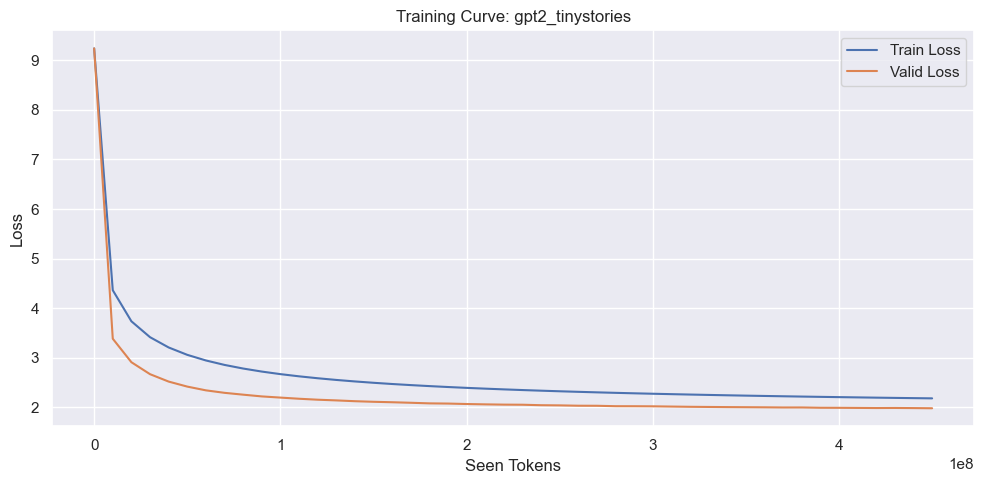

In [ ]:
trainer.train()

In [ ]:
torch.cuda.empty_cache()

# 🔴 **Generate**

In [ ]:
import textwrap

def print_colored_wrapped(prompt, generated, width=100):
    """
    Print prompt and generated text with color and line wrapping, preserving paragraph breaks (\n\n).
    """
    full_text = prompt + generated
    paragraphs = full_text.split('\n\n')  # Split by paragraph

    first = True
    for para in paragraphs:
        # Apply line wrapping per paragraph
        lines = textwrap.wrap(para, width=width)

        for line in lines:
            if first:
                # Print prompt in green and the rest in cyan
                prompt_part = line[:len(prompt)]
                gen_part = line[len(prompt):]
                print(colored(prompt_part, "green") + colored(gen_part, "cyan"))
                prompt = ''  # only on first line
                first = False
            else:
                print(colored(line, "cyan"))

        print()  # extra newline between paragraphs


In [ ]:
prompts = [
    'In last night',
    'Once upon',
    'Once upon a time',
    'One day, a little boy named TimTommy was a smart 3 year old, much smarter']

In [ ]:
for prompt in prompts:
    # Generate n_rep samples
    gen_text = generate(model, tokenizer, prompt, n_rep=3, max_seq_len=128, T=0.9, top_k=10)

    # Print
    print(100*"=")
    for gtxt in gen_text:
        prompt_len = len(prompt)
        generated = gtxt[prompt_len:]
        print_colored_wrapped(prompt, generated, width=100)
        print(100*".")

In last night, there was a big, bright orange bird. The bird was flying around a tree with a long
neck and a red tail. It was a happy bird!

The bird sang a happy song about its nest. It made a soft sound with its beak. It sang a happy song.
A little mouse heard the bird singing. The bird flew around the tree and played with the bird. The
bird sang and the bird felt happy.

The sun and the bird sang for the sun. The sun shone down and the sky was very bright. The bird sang
its new song. Then, it flew away,

....................................................................................................
In last night, Timmy and his family went on an adventure. They went to the park and Timmy saw a big
tree. "I want to climb it, Mommy," he said. "It looks scary," his mom said.

Timmy's mom asked him how the tree was. "That's a very big branch that helps us climb. Do you want
to try it?" Timmy asked. His mom thought it was very pretty, but Timmy didn't listen.

The next day, Timmy too